In [1]:
# import some packages
import numpy as np
import welly

In [2]:
import os
env = %env

In [3]:
from welly import Well

In [4]:
import pandas as pd

In [5]:
picks_dicts = pd.read_table("data/SPE_006/OilSandsDB/PICKS_DIC.TXT", delimiter='\t')

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [6]:
picks_dicts

,HorID,Descriptopn
0,1000,mannville
1,2000,t61
2,3000,t51
3,4000,t41
4,5000,t31
5,6000,clw_wab
6,7000,t21
7,8000,e20
8,9000,t15
9,9500,e14


In [7]:
picks = pd.read_table("data/SPE_006/OilSandsDB/PICKS.TXT", delimiter='\t')
mcmurray_top = picks[picks['HorID'] == 13000]
mcmurray_top.head()

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,SitID,HorID,Pick,Quality
12,102496,13000,475,3
26,102497,13000,515,3
40,102498,13000,480,3
54,102500,13000,549,3
68,102501,13000,529,2


In [8]:
wells = pd.read_table("data/SPE_006/OilSandsDB/WELLS.TXT", delimiter= '\t')

wells.head()

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,SitID,UWI (AGS),UWI
0,102496,0674010812000,00/12-08-067-01W4/0
1,102497,0674020807000,00/07-08-067-02W4/0
2,102498,0674021109000,00/09-11-067-02W4/0
3,102500,0674022910000,00/10-29-067-02W4/0
4,102501,0674023406000,00/06-34-067-02W4/0


In [9]:
import numpy as np

well_locs = pd.read_csv('data/MannvilleWells_LatLong_notab.csv')
well_locs.head()

well_locs.dropna(inplace=True, subset=['Pick'])

well_locs['Pick'] = well_locs['Pick'].astype(float)

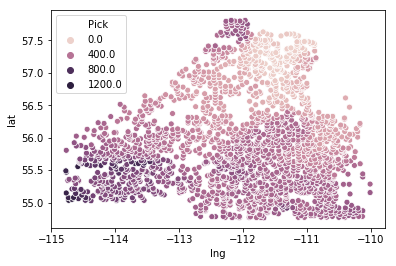

In [10]:
import matplotlib.cm as cm

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

ax = sns.scatterplot(x="lng", y="lat", hue="Pick", data=well_locs)



In [11]:
import sklearn
from sklearn.model_selection import train_test_split

In [12]:
X = well_locs[['lat', 'lng']]
y = well_locs['Pick']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train.head()

2178    513.28
1453    449.28
976     535.84
2095     22.50
864     630.33
Name: Pick, dtype: float64

In [13]:
from sklearn import gaussian_process

#https://stackoverflow.com/questions/45175201/how-can-i-interpolate-station-data-with-kriging-in-python
#kern = gaussian_process.kernels.RBF()
gp = gaussian_process.GaussianProcessRegressor(normalize_y=True)
gp.fit(X_train, y_train)



GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [19]:
import numpy as np
y_samp = gp.sample_y(np.array([-110.2034006,57.807827 ]).reshape(1, -1))
y_samp
X_train.head()

,lat,lng
2178,57.727826,-112.019989
1453,56.211752,-111.174674
976,55.717502,-114.043810
2095,57.419037,-110.883548
864,55.597151,-113.301750


In [15]:
from sklearn import metrics


y_pred = gp.predict(X_test)

metrics.mean_squared_error(y_test, y_pred)

3441.637046200166

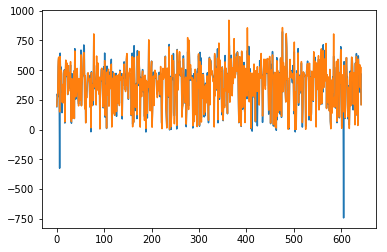

In [16]:
plt.plot(y_pred)
plt.plot(y_test.values)

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


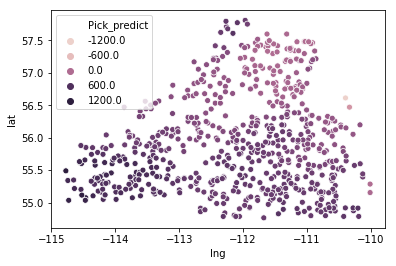

In [17]:
predict_map = X_test
y_pred.shape
predict_map['Pick_predict'] = y_pred.reshape(-1,1)
ax = sns.scatterplot(x="lng", y="lat", hue="Pick_predict", data=predict_map)

(-114.774119, -110.008902)
[[  54.764109   -114.774119  ]
 [  54.82622569 -114.774119  ]
 [  54.88834239 -114.774119  ]
 ...
 [  57.68359361 -110.008902  ]
 [  57.74571031 -110.008902  ]
 [  57.807827   -110.008902  ]]


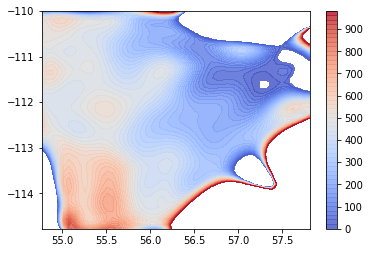

In [28]:
xmin, xmax = well_locs['lat'].min(), well_locs['lat'].max()
ymin, ymax = well_locs['lng'].min(), well_locs['lng'].max()

print((ymin,ymax))

xspace, yspace = np.linspace(xmin, xmax), np.linspace(ymin, ymax)
xx, yy = np.meshgrid(xspace, yspace)


Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

print(np.c_[xx.ravel(), yy.ravel()])

fig, ax = plt.subplots()

contour_plot = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8, levels=range(0,1000,20))
fig.colorbar(contour_plot)